In [21]:
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas
from keras import layers, Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
od.download("https://www.kaggle.com/datasets/gonzajl/riones-cyst-stone-tumor-normal-dataset")

Skipping, found downloaded files in "./riones-cyst-stone-tumor-normal-dataset" (use force=True to force download)


In [4]:
datos = pandas.read_csv("riones-cyst-stone-tumor-normal-dataset/dataset/datos.csv")

In [5]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = "riones-cyst-stone-tumor-normal-dataset/" + nombres[i]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [6]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]

In [7]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [8]:
div_test = int(len(imagenes) * 0.8)
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

In [9]:
def mostrar_grafico_clases(categorias, etiquetas):
    
    cantidades = []
    
    for etiqueta in categorias.values():
        cantidades.append(etiquetas.count(etiqueta))

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias.keys(), cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel("Clases")
    plt.ylabel("Cantidad de Imágenes")
    plt.title("Cantidad de Imágenes por Clase")

    plt.show()

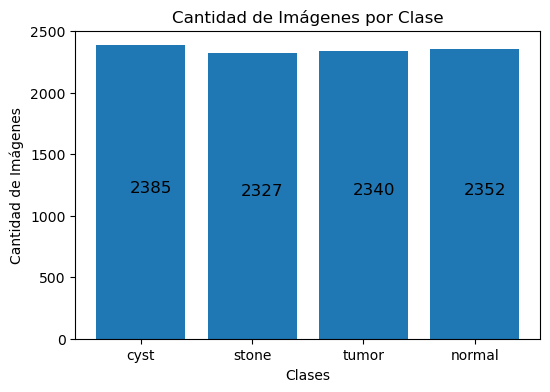

In [10]:
clases = {"cyst": [1, 0, 0, 0], "stone": [0, 1, 0, 0], "tumor": [0, 0, 1, 0], "normal": [0, 0, 0, 1]}
mostrar_grafico_clases(clases, etiquetas_entrenamiento)

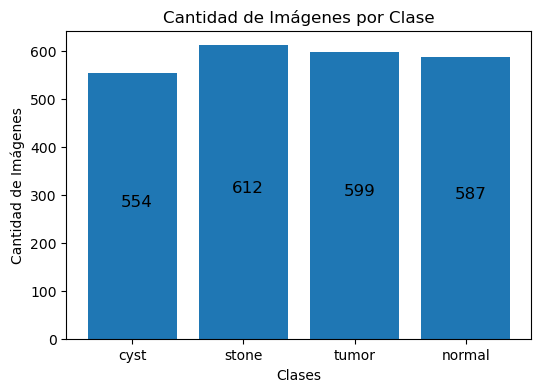

In [11]:
mostrar_grafico_clases(clases, etiquetas_prueba)

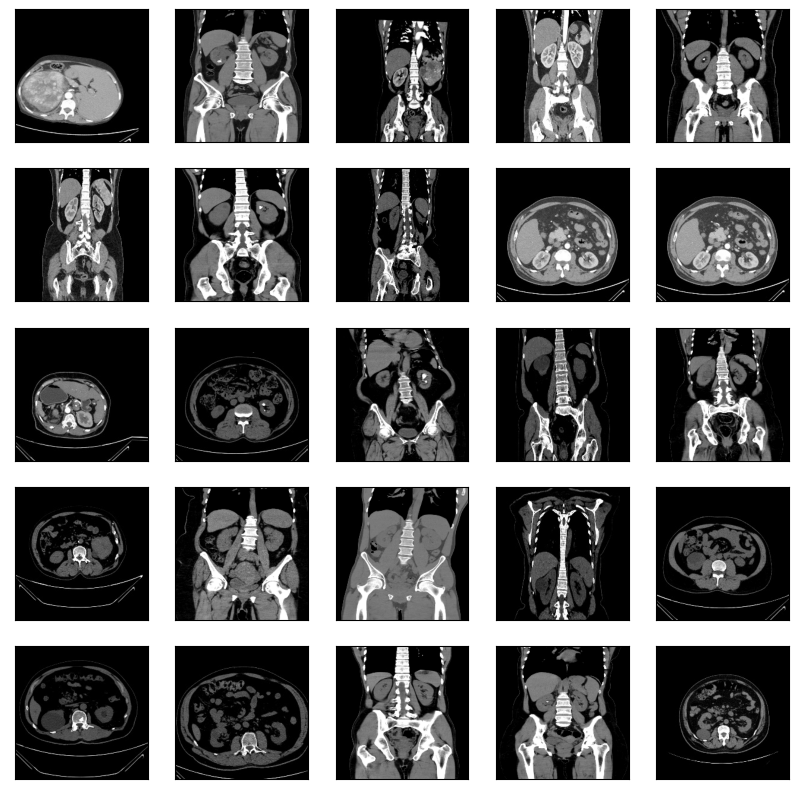

In [12]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [13]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [14]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

base_model.trainable = False

num_classes = 4
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [16]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))

Epoch 1/20


2023-10-28 17:50:32.081035: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5662261248 exceeds 10% of free system memory.


294/294 [==============================] - 281s 948ms/step - loss: 0.6695 - categorical_accuracy: 0.7399 - val_loss: 0.4412 - val_categorical_accuracy: 0.8346
Epoch 2/20
294/294 [==============================] - 275s 937ms/step - loss: 0.3469 - categorical_accuracy: 0.8778 - val_loss: 0.3071 - val_categorical_accuracy: 0.9026
Epoch 3/20
294/294 [==============================] - 276s 939ms/step - loss: 0.2678 - categorical_accuracy: 0.9071 - val_loss: 0.2844 - val_categorical_accuracy: 0.9026
Epoch 4/20
294/294 [==============================] - 277s 941ms/step - loss: 0.2222 - categorical_accuracy: 0.9240 - val_loss: 0.2306 - val_categorical_accuracy: 0.9247
Epoch 5/20
294/294 [==============================] - 278s 946ms/step - loss: 0.1924 - categorical_accuracy: 0.9370 - val_loss: 0.2092 - val_categorical_accuracy: 0.9290
Epoch 6/20
294/294 [==============================] - 276s 940ms/step - loss: 0.1653 - categorical_accuracy: 0.9489 - val_loss: 0.2021 - val_categorical_accuracy

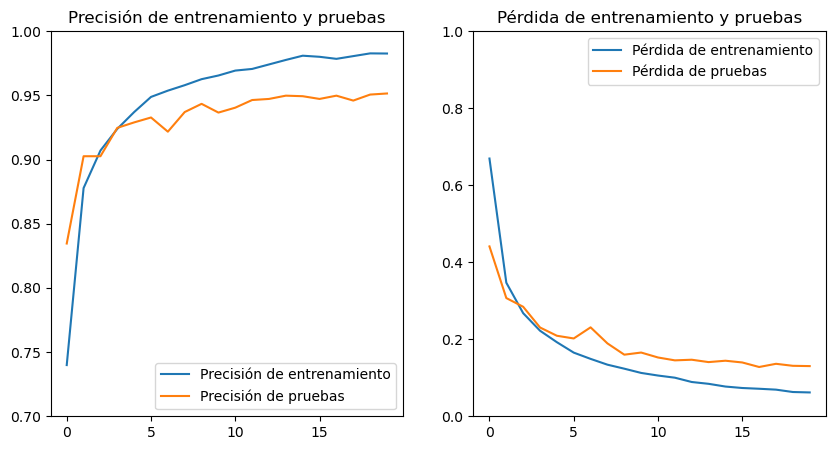

In [17]:
# Graficas de precisión y pérdida del modelo
acc = historial.history['categorical_accuracy']
val_acc = historial.history['val_categorical_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión de entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión de pruebas')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [18]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [19]:
correctas_segun_tipo = [0, 0, 0, 0]
falladas_segun_tipo = [0, 0, 0, 0]

predicciones = model.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))
    
    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1  
    else: 
        falladas_segun_tipo[index] += 1
        
cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [C,  S,  T,  N]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

74/74 [==============================] - 55s 738ms/step
Cantidad de predicciones: 2352
Etiquetas:   [C,  S,  T,  N]
Total:       [563, 631, 589, 569]
Correctas:   [554, 569, 589, 526]
Incorrectas: [9, 62, 0, 43]


In [22]:
!mkdir modelo_exportado

model.save("modelo_exportado/riñones-resnet.h5")